In [1]:
#Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error

from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [46]:
S_Data = pd.read_csv('ED-sepsis.csv')
death = S_Data.death

In [3]:
#Split data to training and validation
X_train, X_val, Y_train, Y_val = train_test_split(S_Data, death, stratify=death, test_size=0.2, random_state = 0)

In [4]:
#Create second dataset for 28-days mortality
X_train_28 = X_train.copy()
X_train_28.loc[X_train_28.HospTime > 28, 'death'] = 0

X_val_28 = X_val.copy()
X_val_28.loc[X_val_28.HospTime > 28, 'death'] = 0

In [5]:
Y_train = X_train[['EDTime', 'EDTime_grp','HospTime', 'death']].copy()

X_train.drop(['EDTime'], axis=1, inplace= True)
X_train.drop(['EDTime_grp'], axis=1, inplace= True)
X_train.drop(['No'], axis=1, inplace= True)
X_train.drop(['HospTime'], axis=1, inplace= True)
X_train.drop(['death'], axis=1, inplace= True)
X_train.drop(['WHITE'], axis=1, inplace= True)
X_train.drop(['ASIAN'], axis=1, inplace= True)
X_train.drop(['HISPANIC OR LATINO'], axis=1, inplace= True)
X_train.drop(['BLACK'], axis=1, inplace= True)
X_train.drop(['OTHER'], axis=1, inplace= True)

Y_val = X_val[['EDTime', 'EDTime_grp','HospTime', 'death']].copy()

X_val.drop(['EDTime'], axis=1, inplace= True)
X_val.drop(['EDTime_grp'], axis=1, inplace= True)
X_val.drop(['No'], axis=1, inplace= True)
X_val.drop(['HospTime'], axis=1, inplace= True)
X_val.drop(['death'], axis=1, inplace= True)
X_val.drop(['WHITE'], axis=1, inplace= True)
X_val.drop(['ASIAN'], axis=1, inplace= True)
X_val.drop(['HISPANIC OR LATINO'], axis=1, inplace= True)
X_val.drop(['BLACK'], axis=1, inplace= True)
X_val.drop(['OTHER'], axis=1, inplace= True)

Y_train_28 = X_train_28[['EDTime', 'EDTime_grp','HospTime', 'death']].copy()
Y_val_28 = X_val_28[['EDTime', 'EDTime_grp','HospTime', 'death']].copy()

In [6]:
#PCA will reset the index. So, reset the index as well so we can match them afterwards.
X_train.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)

Y_train.reset_index(drop = True, inplace = True)
Y_val.reset_index(drop = True, inplace = True)
Y_train_28.reset_index(drop = True, inplace = True)
Y_val_28.reset_index(drop = True, inplace = True)

# Feature Selection

### No Feature Selection

In [7]:
NFS_X_train = X_train.copy()
NFS_X_val = X_val.copy()

### PCA

In [8]:
pca = PCA()
PCA_X_train = pca.fit_transform(X_train)
PCA_variance = pca.explained_variance_ratio_

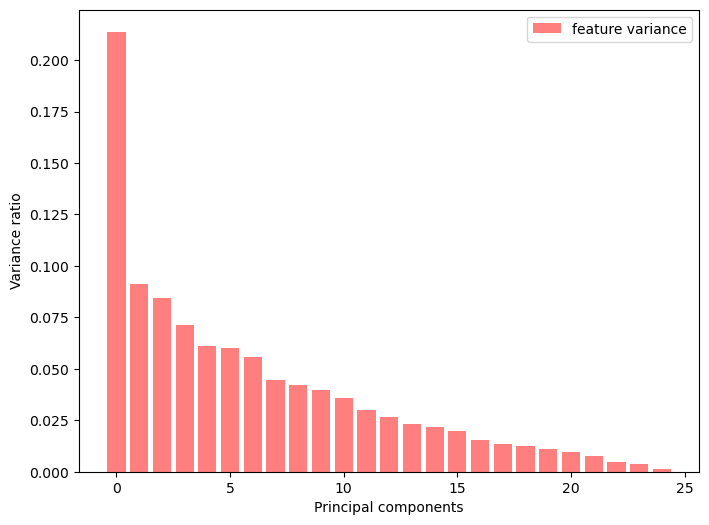

In [9]:
plt.figure(figsize=(8, 6))
plt.bar(range(NFS_X_train.shape[1]), PCA_variance, alpha=0.5, label='feature variance', color = 'red')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [10]:
#Choose the number of variables so that the explained variance is at least 95%.
var_exp = 0
for i in range(NFS_X_train.shape[1]):
    var_exp = var_exp + PCA_variance[i]
    if var_exp >= 0.90:
        num_var = i + 1
        break
print('To explain 90% of the data, we need ' + str(num_var) + ' variables from PCA.')

To explain 90% of the data, we need 15 variables from PCA.


In [11]:
pca90 = PCA(n_components = num_var)
pca90 = pca90.fit(X_train)

In [12]:
PCA_X_train = pd.DataFrame(pca90.transform(X_train))
PCA_X_val = pd.DataFrame(pca90.transform(X_val))

### SPCA

In [13]:
spa = SparsePCA()
SPA_X_train = spa.fit_transform(X_train)
SPA_variance = np.var(SPA_X_train, axis=0)
SPA_variance = SPA_variance / np.sum(SPA_variance)
SPA_variance = -np.sort(-SPA_variance)

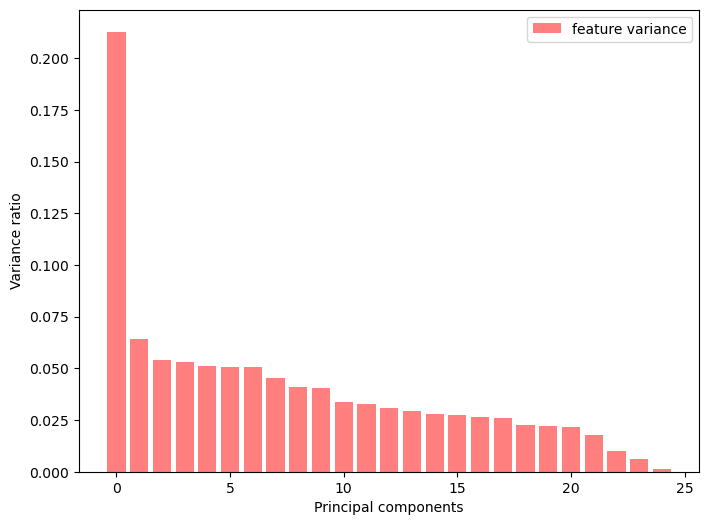

In [14]:
plt.figure(figsize=(8, 6))
plt.bar(range(NFS_X_train.shape[1]), SPA_variance, alpha=0.5, label='feature variance', color = 'red')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [15]:
#Choose the number of variables so that the explained variance is at least 95%.
var_exp = 0
for i in range(NFS_X_train.shape[1]):
    var_exp = var_exp + SPA_variance[i]
    if var_exp >= 0.90:
        num_var = i + 1
        break
print('To explain 90% of the data, we need ' + str(num_var) + ' variables from PCA.')

To explain 90% of the data, we need 19 variables from PCA.


In [16]:
spa90 = SparsePCA(n_components=num_var)
spa90 = spa90.fit(X_train)

In [17]:
SPA_X_train = pd.DataFrame(spa90.transform(X_train))
SPA_X_val = pd.DataFrame(spa90.transform(X_val))

### Simple Logistic Regression
We will perform a simple logistic regression using all the columns provided.<br>

In [18]:
def LogR(X_train, Y_train, X_val, Y_val):
    #Train the logistic regression model
    LogR = LogisticRegression()
    LogR.fit(X_train, Y_train)
    Y_hat_train = LogR.predict(X_train)
    Y_hat_val = LogR.predict(X_val)
    
    #classificiation report on the training and the validation set
    Cl_Rep_tr = classification_report(Y_train, Y_hat_train)
    print("Classification Report on the Training Set")
    print(Cl_Rep_tr)
    Cl_Rep_val = classification_report(Y_val, Y_hat_val)
    print("\nClassification Report on the Validation Set")
    print(Cl_Rep_val)
    
    #Below is the coefficient of the trained logistic regression model
    LogR_coef = pd.DataFrame(zip(X_train.columns, np.transpose(LogR.coef_)), columns=['features', 'coef'])
    print(LogR_coef.loc[LogR_coef['features'] == 'EDTime'])
    
    return LogR_coef

### Logistic Regression: No Feature Selection

In [19]:
NFS_X_train.insert(0, 'EDTime', Y_train['EDTime'])
NFS_X_val.insert(0, 'EDTime', Y_val['EDTime'])

In [20]:
LogR_NFS_coef = LogR(NFS_X_train, Y_train.death, NFS_X_val, Y_val.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1458
           1       0.57      0.06      0.11       257

    accuracy                           0.85      1715
   macro avg       0.71      0.53      0.52      1715
weighted avg       0.81      0.85      0.80      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       365
           1       0.50      0.08      0.14        64

    accuracy                           0.85       429
   macro avg       0.68      0.53      0.53       429
weighted avg       0.81      0.85      0.80       429

  features                   coef
0   EDTime  [-0.2523372418816132]


In [21]:
LogR_NFS_coef_28 = LogR(NFS_X_train, Y_train_28.death, NFS_X_val, Y_val_28.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1465
           1       0.54      0.05      0.09       250

    accuracy                           0.86      1715
   macro avg       0.70      0.52      0.51      1715
weighted avg       0.81      0.86      0.80      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       367
           1       0.44      0.06      0.11        62

    accuracy                           0.85       429
   macro avg       0.65      0.53      0.52       429
weighted avg       0.80      0.85      0.80       429

  features                   coef
0   EDTime  [-0.3866509080444307]


In [22]:
NFS_X = NFS_X_train.append(NFS_X_val, ignore_index = True)

### Logistic Regression: PCA

In [23]:
PCA_X_train.insert(0, 'EDTime', Y_train['EDTime'])
PCA_X_val.insert(0, 'EDTime', Y_val['EDTime'])

In [24]:
LogR_PCA_coef = LogR(PCA_X_train, Y_train.death, PCA_X_val, Y_val.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1458
           1       0.32      0.02      0.04       257

    accuracy                           0.85      1715
   macro avg       0.58      0.51      0.48      1715
weighted avg       0.77      0.85      0.79      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       365
           1       0.57      0.06      0.11        64

    accuracy                           0.85       429
   macro avg       0.71      0.53      0.52       429
weighted avg       0.82      0.85      0.80       429

  features                   coef
0   EDTime  [-0.2724693220298886]


In [25]:
LogR_PCA_coef_28 = LogR(PCA_X_train, Y_train_28.death, PCA_X_val, Y_val_28.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1465
           1       0.23      0.01      0.02       250

    accuracy                           0.85      1715
   macro avg       0.54      0.50      0.47      1715
weighted avg       0.76      0.85      0.79      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       367
           1       0.57      0.06      0.12        62

    accuracy                           0.86       429
   macro avg       0.72      0.53      0.52       429
weighted avg       0.82      0.86      0.81       429

  features                    coef
0   EDTime  [-0.40966468224018865]


In [26]:
PCA_X = PCA_X_train.append(PCA_X_val, ignore_index = True)

### Logistic Regression: SPCA

In [27]:
SPA_X_train.insert(0, 'EDTime', Y_train['EDTime'])
SPA_X_val.insert(0, 'EDTime', Y_val['EDTime'])

In [28]:
LogR_SPA_coef = LogR(SPA_X_train, Y_train.death, SPA_X_val, Y_val.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1458
           1       0.31      0.02      0.03       257

    accuracy                           0.85      1715
   macro avg       0.58      0.50      0.47      1715
weighted avg       0.77      0.85      0.78      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       365
           1       0.67      0.06      0.11        64

    accuracy                           0.86       429
   macro avg       0.76      0.53      0.52       429
weighted avg       0.83      0.86      0.80       429

  features                    coef
0   EDTime  [-0.28762944648131106]


In [29]:
LogR_SPA_coef_28 = LogR(SPA_X_train, Y_train_28.death, SPA_X_val, Y_val_28.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1465
           1       0.27      0.01      0.02       250

    accuracy                           0.85      1715
   macro avg       0.56      0.50      0.47      1715
weighted avg       0.77      0.85      0.79      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       367
           1       1.00      0.06      0.12        62

    accuracy                           0.86       429
   macro avg       0.93      0.53      0.52       429
weighted avg       0.88      0.86      0.81       429

  features                    coef
0   EDTime  [-0.41810561676079633]


In [30]:
SPA_X = SPA_X_train.append(SPA_X_val, ignore_index = True)

### Case Matching Preparation

In [31]:
Y = Y_train.append(Y_val, ignore_index = True)
Y.reset_index(drop = True, inplace = True)
Y.insert(2, 'No', Y.index)

Y_28 = Y_train_28.append(Y_val_28, ignore_index = True)
Y_28.reset_index(drop = True, inplace = True)
Y_28.insert(2, 'No', Y_28.index)

In [32]:
Y_dict_death = {}
for i in range(Y.shape[0]):
    Y_dict_death[Y.iloc[i]['No']] = Y.iloc[i]['death']
    
Y_dict_death_28 = {}
for i in range(Y_28.shape[0]):
    Y_dict_death_28[Y_28.iloc[i]['No']] = Y_28.iloc[i]['death']

### Case Matching

In [33]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from itertools import combinations
from scipy.stats import ttest_ind

In [34]:
NFS_X.insert(0, 'EDTime_grp', Y['EDTime_grp'])
NFS_X.insert(0, 'No', NFS_X.index)
NFS_X.drop(['EDTime'], axis=1, inplace= True)

PCA_X.insert(0, 'EDTime_grp', Y['EDTime_grp'])
PCA_X.insert(0, 'No', PCA_X.index)
PCA_X.drop(['EDTime'], axis=1, inplace= True)

SPA_X.insert(0, 'EDTime_grp', Y['EDTime_grp'])
SPA_X.insert(0, 'No', SPA_X.index)
SPA_X.drop(['EDTime'], axis=1, inplace= True)

In [35]:
def CaseMatch(X, Grp1, Grp2, Grp_Remove_1, Grp_Remove_2, Grp_Remove_3, Weight, bal, caliper):
    #Remove all treatment except 2 groups
    X = X.drop(X[X.EDTime_grp == Grp_Remove_1].index)
    X = X.drop(X[X.EDTime_grp == Grp_Remove_2].index)
    X = X.drop(X[X.EDTime_grp == Grp_Remove_3].index)

    X = X.replace({'EDTime_grp':{Grp1:0, Grp2:1}})
    
    for i in range(1, Weight.shape[0]):
        X.iloc[:, i + 1] = X.iloc[:, i + 1] * Weight.iloc[i,1][0]
    
    psm = PsmPy(X, treatment='EDTime_grp', indx='No', exclude = [])
    psm.logistic_ps(balance = bal)
    psm.predicted_data;
    
    psm.knn_matched(matcher = 'propensity_logit', replacement=False, caliper=caliper)
    
    X_M = psm.df_matched[['No', 'matched_ID']].copy()
    
    return X_M

In [36]:
ones_NFS = LogR_NFS_coef.copy()
for i in range(ones_NFS.shape[0]):
    ones_NFS.iloc[i,1]=[1]

ones_PCA = LogR_PCA_coef.copy()
for i in range(ones_PCA.shape[0]):
    ones_PCA.iloc[i,1]=[1]

ones_SPA = LogR_SPA_coef.copy()
for i in range(ones_SPA.shape[0]):
    ones_SPA.iloc[i,1]=[1]

In [37]:
def check_pval(a, b):
    a = a.dropna()
    b = b.dropna()
    t, p = ttest_ind(a, b, alternative = 'less')
    return p

In [38]:
#Match for each pair of group
def GroupMatch(X, Weight, caliper, Y_dict):
    try:
        X_12 = CaseMatch(X, 1, 2, 3, 4, 5, Weight, True, caliper)
    except:
        X_12 = CaseMatch(X, 1, 2, 3, 4, 5, Weight, False, caliper)
    
    try:
        X_13 = CaseMatch(X, 1, 3, 2, 4, 5, Weight, True, caliper)
    except:
        X_13 = CaseMatch(X, 1, 3, 2, 4, 5, Weight, False, caliper)
        
    try:
        X_14 = CaseMatch(X, 1, 4, 2, 3, 5, Weight, True, caliper)
    except:
        X_14 = CaseMatch(X, 1, 4, 2, 3, 5, Weight, False, caliper)
        
    try:
        X_15 = CaseMatch(X, 1, 5, 2, 3, 4, Weight, True, caliper)
    except:
        X_15 = CaseMatch(X, 1, 5, 2, 3, 4, Weight, False, caliper)
        
    try:
        X_23 = CaseMatch(X, 2, 3, 1, 4, 5, Weight, True, caliper)
    except:
        X_23 = CaseMatch(X, 2, 3, 1, 4, 5, Weight, False, caliper)
        
    try:
        X_24 = CaseMatch(X, 2, 4, 1, 3, 5, Weight, True, caliper)
    except:
        X_24 = CaseMatch(X, 2, 4, 1, 3, 5, Weight, False, caliper)
        
    try:
        X_25 = CaseMatch(X, 2, 5, 1, 3, 4, Weight, True, caliper)
    except:
        X_25 = CaseMatch(X, 2, 5, 1, 3, 4, Weight, False, caliper)
        
    try:
        X_34 = CaseMatch(X, 3, 4, 1, 2, 5, Weight, True, caliper)
    except:
        X_34 = CaseMatch(X, 3, 4, 1, 2, 5, Weight, False, caliper)
        
    try:
        X_35 = CaseMatch(X, 3, 5, 1, 2, 4, Weight, True, caliper)
    except:
        X_35 = CaseMatch(X, 3, 5, 1, 2, 4, Weight, False, caliper)
        
    try:
        X_45 = CaseMatch(X, 4, 5, 1, 2, 3, Weight, True, caliper)
    except:
        X_45 = CaseMatch(X, 4, 5, 1, 2, 3, Weight, False, caliper)
    
    X = []
    
    X_12 = X_12.dropna()
    X_12['No_death'] = X_12['No'].apply(lambda x: Y_dict[x])
    X_12['matched_ID_death'] = X_12['matched_ID'].apply(lambda x: Y_dict[x])
    X_13 = X_13.dropna()
    X_13['No_death'] = X_13['No'].apply(lambda x: Y_dict[x])
    X_13['matched_ID_death'] = X_13['matched_ID'].apply(lambda x: Y_dict[x])
    X_14 = X_14.dropna()
    X_14['No_death'] = X_14['No'].apply(lambda x: Y_dict[x])
    X_14['matched_ID_death'] = X_14['matched_ID'].apply(lambda x: Y_dict[x])
    X_15 = X_15.dropna()
    X_15['No_death'] = X_15['No'].apply(lambda x: Y_dict[x])
    X_15['matched_ID_death'] = X_15['matched_ID'].apply(lambda x: Y_dict[x])
    X_23 = X_23.dropna()
    X_23['No_death'] = X_23['No'].apply(lambda x: Y_dict[x])
    X_23['matched_ID_death'] = X_23['matched_ID'].apply(lambda x: Y_dict[x])
    X_24 = X_24.dropna()
    X_24['No_death'] = X_24['No'].apply(lambda x: Y_dict[x])
    X_24['matched_ID_death'] = X_24['matched_ID'].apply(lambda x: Y_dict[x])
    X_25 = X_25.dropna()
    X_25['No_death'] = X_25['No'].apply(lambda x: Y_dict[x])
    X_25['matched_ID_death'] = X_25['matched_ID'].apply(lambda x: Y_dict[x])
    X_34 = X_34.dropna()
    X_34['No_death'] = X_34['No'].apply(lambda x: Y_dict[x])
    X_34['matched_ID_death'] = X_34['matched_ID'].apply(lambda x: Y_dict[x])
    X_35 = X_35.dropna()
    X_35['No_death'] = X_35['No'].apply(lambda x: Y_dict[x])
    X_35['matched_ID_death'] = X_35['matched_ID'].apply(lambda x: Y_dict[x])
    X_45 = X_45.dropna()
    X_45['No_death'] = X_45['No'].apply(lambda x: Y_dict[x])
    X_45['matched_ID_death'] = X_45['matched_ID'].apply(lambda x: Y_dict[x])
    
    X.append(X_12)
    X.append(X_13)
    X.append(X_14)
    X.append(X_15)
    X.append(X_23)
    X.append(X_24)
    X.append(X_25)
    X.append(X_34)
    X.append(X_35)
    X.append(X_45)
    
    num = []
    mor1 = []
    mor2 = []
    pval = []
    for i in range(10):
        num.append(X[i].shape[0])
        mor1.append(sum(X[i]['No_death'])/num[i])
        mor2.append(sum(X[i]['matched_ID_death'])/num[i])
        pval.append(check_pval(X[i]['No_death'], X[i]['matched_ID_death']))
        
    X_summary = pd.DataFrame()
    X_summary['Group 1'] = [1, 1, 1, 1, 2, 2, 2, 3, 3, 4]
    X_summary['Group 2'] = [2, 3, 4, 5, 3, 4, 5, 4, 5, 5]
    X_summary['Mortality Rate 1'] = mor1
    X_summary['Mortality Rate 2'] = mor2
    X_summary['Number of cases'] = num
    X_summary['P-value'] = pval

    
    return X_summary

### No Feature Selection

Without caliper

In [39]:
#Without Weight
NFS_M_NW_nocal = GroupMatch(NFS_X, ones_NFS, None, Y_dict_death)
NFS_M_NW_28_nocal = GroupMatch(NFS_X, ones_NFS, None, Y_dict_death_28)
#With Weight
NFS_M_GM_nocal = GroupMatch(NFS_X, LogR_NFS_coef, None, Y_dict_death)
NFS_M_28_nocal = GroupMatch(NFS_X, LogR_NFS_coef_28, None, Y_dict_death_28)

With caliper = 0.2

In [40]:
#Without Weight
NFS_M_NW_cal02 = GroupMatch(NFS_X, ones_NFS, 0.2, Y_dict_death)
NFS_M_NW_28_cal02 = GroupMatch(NFS_X, ones_NFS, 0.2, Y_dict_death_28)
#With Weight
NFS_M_GM_cal02 = GroupMatch(NFS_X, LogR_NFS_coef, 0.2, Y_dict_death)
NFS_M_28_cal02 = GroupMatch(NFS_X, LogR_NFS_coef_28, 0.2, Y_dict_death_28)

### PCA

Without caliper

In [41]:
#Without Weight
PCA_M_NW_nocal = GroupMatch(PCA_X, ones_PCA, None, Y_dict_death)
PCA_M_NW_28_nocal = GroupMatch(PCA_X, ones_PCA, None, Y_dict_death_28)
#With Weight
PCA_M_GM_nocal = GroupMatch(PCA_X, LogR_PCA_coef, None, Y_dict_death)
PCA_M_28_nocal = GroupMatch(PCA_X, LogR_PCA_coef_28, None, Y_dict_death_28)

With caliper = 0.2

In [42]:
#Without Weight
PCA_M_NW_cal02 = GroupMatch(PCA_X, ones_PCA, 0.2, Y_dict_death)
PCA_M_NW_28_cal02 = GroupMatch(PCA_X, ones_PCA, 0.2, Y_dict_death_28)
#With Weight
PCA_M_GM_cal02 = GroupMatch(PCA_X, LogR_PCA_coef, 0.2, Y_dict_death)
PCA_M_28_cal02 = GroupMatch(PCA_X, LogR_PCA_coef_28, 0.2, Y_dict_death_28)

### SPCA

Without caliper

In [43]:
#Without Weight
SPA_M_NW_nocal = GroupMatch(SPA_X, ones_SPA, None, Y_dict_death)
SPA_M_NW_28_nocal = GroupMatch(SPA_X, ones_SPA, None, Y_dict_death_28)
#With Weight
SPA_M_GM_nocal = GroupMatch(SPA_X, LogR_SPA_coef, None, Y_dict_death)
SPA_M_28_nocal = GroupMatch(SPA_X, LogR_SPA_coef_28, None, Y_dict_death_28)

With caliper = 0.2

In [44]:
#Without Weight
SPA_M_NW_cal02 = GroupMatch(SPA_X, ones_SPA, 0.2, Y_dict_death)
SPA_M_NW_28_cal02 = GroupMatch(SPA_X, ones_SPA, 0.2, Y_dict_death_28)
#With Weight
SPA_M_GM_cal02 = GroupMatch(SPA_X, LogR_SPA_coef, 0.2, Y_dict_death)
SPA_M_28_cal02 = GroupMatch(SPA_X, LogR_SPA_coef_28, 0.2, Y_dict_death_28)

## Export results to CSV

In [45]:
with pd.ExcelWriter('Summary.xlsx') as writer:
    NFS_M_NW_nocal.to_excel(writer, sheet_name='NFS_M_NW_nocal')
    NFS_M_NW_28_nocal.to_excel(writer, sheet_name='NFS_M_NW_28_nocal')
    NFS_M_GM_nocal.to_excel(writer, sheet_name='NFS_M_GM_nocal')
    NFS_M_28_nocal.to_excel(writer, sheet_name='NFS_M_28_nocal')
    NFS_M_NW_cal02.to_excel(writer, sheet_name='NFS_M_NW_cal02')
    NFS_M_NW_28_cal02.to_excel(writer, sheet_name='NFS_M_NW_28_cal02')
    NFS_M_GM_cal02.to_excel(writer, sheet_name='NFS_M_GM_cal02')
    NFS_M_28_cal02.to_excel(writer, sheet_name='NFS_M_28_cal02')
    PCA_M_NW_nocal.to_excel(writer, sheet_name='PCA_M_NW_nocal')
    PCA_M_NW_28_nocal.to_excel(writer, sheet_name='PCA_M_NW_28_nocal')
    PCA_M_GM_nocal.to_excel(writer, sheet_name='PCA_M_GM_nocal')
    PCA_M_28_nocal.to_excel(writer, sheet_name='PCA_M_28_nocal')
    PCA_M_NW_cal02.to_excel(writer, sheet_name='PCA_M_NW_cal02')
    PCA_M_NW_28_cal02.to_excel(writer, sheet_name='PCA_M_NW_28_cal02')
    PCA_M_GM_cal02.to_excel(writer, sheet_name='PCA_M_GM_cal02')
    PCA_M_28_cal02.to_excel(writer, sheet_name='PCA_M_28_cal02')
    SPA_M_NW_nocal.to_excel(writer, sheet_name='SPA_M_NW_nocal')
    SPA_M_NW_28_nocal.to_excel(writer, sheet_name='SPA_M_NW_28_nocal')
    SPA_M_GM_nocal.to_excel(writer, sheet_name='SPA_M_GM_nocal')
    SPA_M_28_nocal.to_excel(writer, sheet_name='SPA_M_28_nocal')
    SPA_M_NW_cal02.to_excel(writer, sheet_name='SPA_M_NW_cal02')
    SPA_M_NW_28_cal02.to_excel(writer, sheet_name='SPA_M_NW_28_cal02')
    SPA_M_GM_cal02.to_excel(writer, sheet_name='SPA_M_GM_cal02')
    SPA_M_28_cal02.to_excel(writer, sheet_name='SPA_M_28_cal02')